<a href="https://colab.research.google.com/github/amber3536/Wildfire_Prediction/blob/main/FireChip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from concurrent.futures import ThreadPoolExecutor
from datetime import datetime, timedelta
import os
from pathlib import Path
from random import sample
import shutil
import subprocess
import math
import pyproj
import json

import shapely.wkt
from shapely.geometry import Polygon
import geopandas as gpd
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from shapely.geometry import box

!pip install geocube
from geocube.api.core import make_geocube
import rasterio
from rasterio.errors import RasterioIOError
from rasterio.vrt import WarpedVRT
from rasterio.mask import mask
from sklearn.cluster import DBSCAN
from pyproj import CRS
from shapely.geometry import mapping, MultiPoint, shape
from shapely.ops import transform, nearest_points
from shapely.ops import transform as shapely_tf
import affine

!pip install dem_stitcher
from dem_stitcher.stitcher import stitch_dem

!pip install xarray[complete]
!pip install zarr
import xarray as xarr
import zarr
from rasterio.enums import Resampling
!pip install s3fs
import s3fs

  Using cached botocore-1.32.3-py3-none-any.whl (11.4 MB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.31.64
    Uninstalling botocore-1.31.64:
      Successfully uninstalled botocore-1.31.64
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.7.0 requires botocore<1.31.65,>=1.31.16, but you have botocore 1.32.3 which is incompatible.


  Using cached botocore-1.31.64-py3-none-any.whl (11.3 MB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.32.3
    Uninstalling botocore-1.32.3:
      Successfully uninstalled botocore-1.32.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.29.3 requires botocore<1.33.0,>=1.32.3, but you have botocore 1.31.64 which is incompatible.


In [13]:
DEFAULT_PARAMS = [
    "air_pressure_at_mean_sea_level",
    "air_temperature_at_2_metres",
    "air_temperature_at_2_metres_1hour_Maximum",
    "air_temperature_at_2_metres_1hour_Minimum",
    "dew_point_temperature_at_2_metres",
    "eastward_wind_at_100_metres",
    "eastward_wind_at_10_metres",
    "integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation",
    "lwe_thickness_of_surface_snow_amount",
    "northward_wind_at_100_metres",
    "northward_wind_at_10_metres",
    "precipitation_amount_1hour_Accumulation",
    "sea_surface_temperature",
    "snow_density",
    "surface_air_pressure",
]

CHIP_SIZE = (64, 64)

In [14]:
urls = []
for i in range(10):
    year = 2012 + i
    u = "https://firms.modaps.eosdis.nasa.gov/data/country/viirs-snpp/" + str(year) + "/viirs-snpp_" + str(year) + "_United_States.csv"
    urls.append(u)


In [15]:
def cluster_fires(fire_dataframe, min_cluster_points=25):
    """
    Given a geodataframe of fire points, for each date, create clusters
    :param fire_dataframe: geodataframe of fire points
    :param min_cluster_points: minimum number of fire points in a cluster for it to be kept
    :return: geodataframe of fire points that belong to a cluster
    """
    clustered_fires_for_dates = []
    number_of_clusters = 0
    for date in fire_dataframe["acq_date"].unique().tolist():
        fires_for_date = fire_dataframe[fire_dataframe["acq_date"] == date]
        #fire_clusters = DBSCAN(eps=0.01, min_samples=1).fit(
        fire_clusters = DBSCAN(eps=0.1, min_samples=1).fit(
            fires_for_date[["longitude", "latitude"]].values
        )

        # add clusters label
        cluster_labels = fire_clusters.labels_ + number_of_clusters
        number_of_clusters += fire_clusters.labels_.max() + 1

        cluster_labels = pd.Series(cluster_labels, name="label")
        # shift to match date selection
        cluster_labels.index += fires_for_date.index.min()
        clustered_fires_for_dates.append(
            pd.concat([fires_for_date, cluster_labels], axis=1)
        )

    clustered_fires = pd.concat(clustered_fires_for_dates)
    # drop clusters with < min_cluster_points
    label_counts = clustered_fires["label"].value_counts()
    clustered_fires["label"] = clustered_fires["label"].apply(
        lambda x: x if label_counts[x] >= min_cluster_points else -1
    )
    clustered_fires = clustered_fires[clustered_fires["label"] != -1]

    # reset label to be continuous
    clustered_fires['label'] = clustered_fires.groupby('label').ngroup()
    return clustered_fires


def convert_wgs_to_utm(lon, lat):
    """
    Stolen from
    https://stackoverflow.com/questions/40132542/get-a-cartesian-projection-accurate-around-a-lat-lng-pair
    :param lon: Longitude float
    :param lat: Latitude float
    :return: The utm code appropriate for this AOI
    """
    utm_band = str((math.floor((lon + 180) / 6) % 60) + 1)
    if len(utm_band) == 1:
        utm_band = "0" + utm_band
    if lat >= 0:
        epsg_code = "326" + utm_band
        return epsg_code
    epsg_code = "327" + utm_band
    return epsg_code


def buffer_point(point, buffer_m=16000, output_4326=False):
    """
    Given a WGS 84 shapely point, figure out UTM proj for it, reproject point to that utm,
    buffer it and return the bounding box
    :param point: shapely point in EPSG:4326
    :param buffer_m: metres to buffer the point by
    :param output_4326: bool, should the buffered polygon be converted back to EPSG:4326
    :return: shapely polygon and the UTM CRS for it
    """
    epsg_code = int(convert_wgs_to_utm(point.x, point.y))
    utm_crs = CRS.from_epsg(epsg_code)

    # project point 4326 to utm
    wgs84_to_utm_transformer = pyproj.Transformer.from_proj(
        pyproj.Proj(4326),  # source coordinate system
        utm_crs,  # destination coordinate system
        always_xy=True,
    )
    projected_point = transform(wgs84_to_utm_transformer.transform, point)

    # buffer point
    buffered_point = projected_point.buffer(buffer_m).bounds
    bbox = box(
        minx=buffered_point[0],
        miny=buffered_point[1],
        maxx=buffered_point[2],
        maxy=buffered_point[3],
    )

    if output_4326:
        # reproject polygon back to 4326
        utm_to_wgs84_transformer = pyproj.Transformer.from_proj(
            utm_crs, pyproj.Proj(4326)  # source coordinate system
        )  # destination coordinate system
        bbox = transform(utm_to_wgs84_transformer.transform, bbox)

    return bbox, utm_crs


def create_chip_bounds(clustered_fires):
    """
    Given a geodataframe of clustered fire points create chip bbox and save metadata to csv
    :param clustered_fires: geodataframe of clustered fire points
    :param output_fp: directory for output file to be written to
    :return: filepath of the records.csv created/updated
    """
    chip_bounds = []
    for cluster in clustered_fires["label"].unique().tolist():
        clustered_fire = clustered_fires[clustered_fires["label"] == cluster]
        date = clustered_fire["acq_date"].values[0]
        multipoint_fire_feature = MultiPoint([x for x in clustered_fire.geometry])
        # convert to polygon & get centre
        multipoint_fire_feature_centre = multipoint_fire_feature.convex_hull.centroid
        # get closest point to centre
        central_fire_point = nearest_points(
            multipoint_fire_feature, multipoint_fire_feature_centre
        )[0]

        # build bbox around the clusters central fire point
        bbox_4326, utm_crs = buffer_point(
            central_fire_point, buffer_m=15750, output_4326=True
        )
        bbox_4326_geojson = json.dumps(
            mapping(transform(lambda x, y: (y, x), bbox_4326))
        )
        chip = make_geocube(
            vector_data=gpd.GeoDataFrame(
                geometry=[central_fire_point], crs="EPSG:4326"
            ),
            resolution=(-500, 500),
            output_crs=utm_crs,
            geom=bbox_4326_geojson,
        )

        chip_bounds.append([cluster, *chip.rio.bounds(), utm_crs.to_epsg(), date])

    return pd.DataFrame(
        chip_bounds, columns=["idx", "left", "bottom", "right", "top", "epsg", "date"]
    )


def fires_from_topleft(top_left, epsg_code, date_to_query, fires):
    """
    Given input chip parameters, load fire data and rasterize the points
    :param top_left: list of the top left coordinates of the chip
    :param epsg_code: EPSG code for top_left
    :param date_to_query: date of the fire data to load
    :param fires : gpd.GeoDataFrame or filename
    :return: xarray.Dataset containing rasterized fire points
    """
    aoi = bounds_to_geojson(
        rasterio.coords.BoundingBox(
            left=top_left[1],
            right=top_left[1] + 32000,
            bottom=top_left[0] - 32000,
            top=top_left[0],
        )
    )

    # reproj the bbox from utm to 4326
    utm_to_wgs84_transformer = pyproj.Transformer.from_crs(
        epsg_code, 4326, always_xy=True
    ).transform
    aoi_wgs84 = shapely_tf(utm_to_wgs84_transformer, shape(aoi))

    #print(aoi_wgs84)

    # load fire data intersecting chip bbox
    if isinstance(fires, str):
        fires_in_chip = gpd.read_file(fires, layer="merge", bbox=aoi_wgs84)
    else:
        chip_poly = gpd.GeoDataFrame(geometry=[aoi_wgs84], crs="EPSG:4326")
        m = fires[fires["acq_date"] == date_to_query]
        j = m['geometry'].clip(chip_poly).keys()
        fires_in_chip = m.loc[j]
        #fires_in_chip = fires[fires["acq_date"] == date_to_query].clip(chip_poly)

    #fires_in_chip = fires_in_chip[fires_in_chip["acq_date"] == date_to_query]

    if fires_in_chip.empty:
        # possible if fire dies "next day"
        fires_in_chip = gpd.GeoDataFrame(geometry=[aoi_wgs84.centroid], crs="EPSG:4326")
        fires_in_chip["bool"] = 0
        fires_in_chip["frp"] = 0
    else:
        fires_in_chip["bool"] = 1
        fires_in_chip["frp"] = pd.to_numeric(fires_in_chip["frp"])


    bbox_4326, utm_crs = buffer_point(
        aoi_wgs84.centroid, buffer_m=15750, output_4326=True
    )
    bbox_4326_geojson = json.dumps(mapping(transform(lambda x, y: (y, x), bbox_4326)))

    # rasterize
    fire_array = make_geocube(
        vector_data=fires_in_chip,
        measurements=["bool", "frp"],
        resolution=(-500, 500),
        output_crs=epsg_code,
        fill=0,
        geom=bbox_4326_geojson,
    )
    return fire_array


def bounds_to_geojson(bounds):
    """
    Convert a rio BoundingBox to geojson with optional buffer
    :param bounds: BoundingBox
    :return: geojson with applied buffer
    """
    return {
        "type": "Polygon",
        "coordinates": [
            [
                [bounds.left, bounds.top],
                [bounds.right, bounds.top],
                [bounds.right, bounds.bottom],
                [bounds.left, bounds.bottom],
                [bounds.left, bounds.top],
            ]
        ],
    }


def read_geospatial_file(aoi, dst_crs, dst_transform, src):
    """
    Reads a geospatial raster in the desired transform
    :param aoi: aoi to clip to
    :param dst_crs: destination crs
    :param dst_transform: destination transform
    :param src: open rasterio file handler
    :return: the data
    """
    with WarpedVRT(
        src,
        **{
            "height": CHIP_SIZE[0],
            "width": CHIP_SIZE[1],
            "transform": dst_transform,
            "crs": dst_crs,
        },
    ) as vrt:
        data, tf = mask(vrt, [aoi], crop=True)
    return data, tf


def landcover_from_topleft(top_left, epsg):
    """
    Given input chip parameters, load landcover data and reproject to the chip CRS
    :param top_left: list of the top left coordinates of the chip
    :param epsg_code: EPSG code for top_left
    :return: numpy array of the landcover data
    """
    aoi = bounds_to_geojson(
        rasterio.coords.BoundingBox(
            left=top_left[1],
            right=top_left[1] + 32000,
            bottom=top_left[0] - 32000,
            top=top_left[0],
        )
    )
    os.environ['AWS_NO_SIGN_REQUEST'] = 'True'
    with rasterio.open(
        "s3://esa-worldcover/v100/2020/ESA_WorldCover_10m_2020_v100_Map_AWS.vrt"
    ) as src:
        dst_crs = CRS.from_epsg(epsg)
        dst_transform = affine.Affine(500, 0.0, top_left[1], 0.0, -500, top_left[0])
        landcover_data, tf = read_geospatial_file(aoi, dst_crs, dst_transform, src)
    return landcover_data[0]

def atmospheric_from_topleft(topleft, epsg_code, date, params):
    """
    Given input chip and desired era5 variables, load data, reproject to the chip CRS and resample
    :param sample: chip parameters
    :param params: list of era5 variables to load
    :return: xarray.Dataset of atmospheric data
    """
    date_to_query = datetime.strptime(date, "%Y-%m-%d")
    datasets = []
    for param in DEFAULT_PARAMS:
        datasets.append(
            f"s3://era5-pds/zarr/{date_to_query.year}/{str.zfill(str(date_to_query.month), 2)}/data/{param}.zarr/"
        )
    #print(datasets)
    #stacked_dataset = xarr.open_mfdataset(
     #   datasets, engine="zarr", storage_options={"anon": True})
    fs = s3fs.S3FileSystem(anon=True)
    stacked_dataset = xarr.open_mfdataset([s3fs.S3Map(url, s3=fs) for url in datasets], engine='zarr')

    dataset_for_date = stacked_dataset.sel(
        time0=date_to_query.strftime("%Y-%m-%d"),
        time1=date_to_query.strftime("%Y-%m-%d"),
    )

    # We use rio-xarray here to add geospatial data to the xarray
    dataset_for_date = dataset_for_date.rename(lon="x", lat="y")
    dataset_for_date["x"] = dataset_for_date["x"] - 180
    dataset_for_date = dataset_for_date.drop_vars("time1_bounds")
    wgs84_crs = CRS.from_epsg(4326)

    utm_to_wgs84_transformer = pyproj.Transformer.from_crs(
        epsg_code, 4326, always_xy=True
    ).transform

    aoi = {
        "type": "Polygon",
        "coordinates": [
            [
                [topleft[1], topleft[0] - 32000],
                [topleft[1] + 32000, topleft[0] - 32000],
                [topleft[1] + 32000, topleft[0]],
                [topleft[1], topleft[0]],
                [topleft[1], topleft[0] - 32000],
            ]
        ],
    }

    filtered_wgs84 = shapely_tf(utm_to_wgs84_transformer, shape(aoi))
    left84, bottom84, right84, top84 = shape(filtered_wgs84).bounds

    # We do a rough crop in the first instance as rioxarray doesn't need to reproject the whole globe!
    cropped_dataset = dataset_for_date.sel(
        y=slice(top84 + 0.25, bottom84 - 0.25), x=slice(left84 - 0.25, right84 + 0.25)
    )
    dst_transform = affine.Affine(500, 0.0, topleft[1], 0.0, -500, topleft[0])

    cropped_dataset.rio.write_crs(wgs84_crs, inplace=True)
    for i in params:
        cropped_dataset[i] = cropped_dataset[i].astype("float64")
    reprojected_dataset = cropped_dataset.rio.reproject(
        f"EPSG:{epsg_code}",
        transform=dst_transform,
        shape=CHIP_SIZE,
        resampling=Resampling.cubic,
    )
    reprojected_dataset = (
        reprojected_dataset.resample(time0="1D").interpolate("linear").compute()
    )
    reprojected_dataset = (
        reprojected_dataset.resample(time1="1D").interpolate("linear").compute()
    )
    return reprojected_dataset


In [16]:
def createManifest():
  manifest = pd.DataFrame()
  frames = []

  for url in urls:
      new_df = pd.read_csv(url, low_memory=False)
      df_fire = gpd.GeoDataFrame(new_df, geometry=gpd.points_from_xy(new_df.longitude, new_df.latitude), crs='EPSG:4326')
      frames.append(df_fire)

      df_fire_clustered = cluster_fires(df_fire)
      #frames.append(df_fire_clustered)

      chip_bounds = create_chip_bounds(df_fire_clustered)

      if manifest.empty:
          manifest=chip_bounds
      else:
          chip_bounds.idx = chip_bounds.idx + manifest.idx.max() + 1
          manifest = pd.concat([manifest, chip_bounds])
  return manifest, frames


In [17]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


## The commented out code below takes a long time to run (~20-30 min on my computer). Run it to write files to Google Drive once so that you can just use them from there

In [18]:
# manifest, frames = createManifest()

# manifest.to_csv('manifest.csv')
# !cp manifest.csv "drive/My Drive/"

# for i in range(len(frames)):
#    path = "drive/My Drive/frames-" + str(i) + '.csv'
#    with open(path, 'w', encoding = 'utf-8-sig') as f:
#      frames[i].to_csv(f)

In [19]:
manifest = pd.read_csv("drive/MyDrive/manifest.csv")

In [20]:
manifest.shape

(21550, 8)

In [21]:
manifest.head(10)

,Unnamed: 0,idx,left,bottom,right,top,epsg,date
0,0,0,265500.0,2129000.0,297500.0,2161000.0,32605,2012-01-20
1,1,1,493000.0,3087500.0,525000.0,3119500.0,32617,2012-01-20
2,2,2,352500.0,3334500.0,384500.0,3366500.0,32617,2012-01-20
3,3,3,722000.0,3320000.0,754000.0,3352000.0,32616,2012-01-20
4,4,4,266000.0,2128500.0,298000.0,2160500.0,32605,2012-01-21
5,5,5,417000.0,3281500.0,449000.0,3313500.0,32615,2012-01-24
6,6,6,352000.0,3341500.0,384000.0,3373500.0,32617,2012-01-26
7,7,7,747500.0,4188500.0,779500.0,4220500.0,32610,2012-01-28
8,8,8,554500.0,3256000.0,586500.0,3288000.0,32615,2012-01-28
9,9,9,266000.0,2128500.0,298000.0,2160500.0,32605,2012-01-28


In [22]:
def get_elevation(top_left, epsg_code):
  dst_area_or_point = 'Point'
  dst_ellipsoidal_height = True
  dem_name = 'glo_30'

  aoi = bounds_to_geojson(
    rasterio.coords.BoundingBox(
        left=top_left[1],
        right=top_left[1] + 32000,
        bottom=top_left[0] - 32000,
        top=top_left[0],
    )
  )
    # reproj the bbox from utm to 4326
  utm_to_wgs84_transformer = pyproj.Transformer.from_crs(
      epsg_code, 4326, always_xy=True
  ).transform
  aoi_wgs84 = shapely_tf(utm_to_wgs84_transformer, shape(aoi))

  poly = gpd.GeoDataFrame(geometry=[aoi_wgs84], crs="EPSG:4326")
  poly_b = list(poly["geometry"][0].exterior.coords)

  left = poly_b[0][0]
  right = poly_b[1][0]
  top = poly_b[0][1]
  bottom = poly_b[2][1]

  bounds = [left, bottom, right, top]

  X, p = stitch_dem(bounds,
                  dem_name=dem_name,
                  dst_ellipsoidal_height=dst_ellipsoidal_height,
                  dst_area_or_point=dst_area_or_point)
  return X, p

In [23]:
def process(num, fires):
  chip = manifest.iloc[num]
  chip_idx, left, bottom, top, right, epsg, chip_date = chip["idx"], chip["left"], chip["bottom"], chip["top"], chip["right"], chip["epsg"], chip["date"]
  sel = int(chip_date.split('-')[0]) - 2012

  # Use this code if using Google Drive
  # f = 'drive/MyDrive/frames/frames-' + str(sel) + '.csv'
  # new_df = pd.read_csv(f, low_memory=False)
  # fires = gpd.GeoDataFrame(new_df, geometry=gpd.points_from_xy(new_df.longitude, new_df.latitude), crs='EPSG:4326')

  # Use this code if not
  #fires = gpd.GeoDataFrame(frames[sel])

  todays_fires = fires_from_topleft([top, left], str(epsg), chip_date, fires)

  return todays_fires

In [24]:
def process_tomorrow(num, fires):
  chip = manifest.iloc[num]
  chip_idx, left, bottom, top, right, epsg, chip_date = chip["idx"], chip["left"], chip["bottom"], chip["top"], chip["right"], chip["epsg"], chip["date"]

  tomorrows_date = (datetime.strptime(chip_date, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d')
  sel = int(tomorrows_date.split('-')[0]) - 2012

  # Use this code if using Google Drive
  # f = 'drive/MyDrive/frames/frames-' + str(sel) + '.csv'
  # new_df = pd.read_csv(f, low_memory=False)
  # fires = gpd.GeoDataFrame(new_df, geometry=gpd.points_from_xy(new_df.longitude, new_df.latitude), crs='EPSG:4326')

  # Use this code if not
  #fires = gpd.GeoDataFrame(frames[sel])

  tomorrow_fire = fires_from_topleft([top, left], str(epsg), tomorrows_date, fires)

  return tomorrow_fire

In [25]:
def get_frame(i):
  chip = manifest.iloc[i]
  chip_idx, left, bottom, top, right, epsg, chip_date = chip["idx"], chip["left"], chip["bottom"], chip["top"], chip["right"], chip["epsg"], chip["date"]
  sel = int(chip_date.split('-')[0]) - 2012
   # Use this code if using Google Drive
  f = 'drive/MyDrive/frames/frames-' + str(sel) + '.csv'
  new_df = pd.read_csv(f, low_memory=False)
  fires = gpd.GeoDataFrame(new_df, geometry=gpd.points_from_xy(new_df.longitude, new_df.latitude), crs='EPSG:4326')
  return fires

In [26]:
def get_tomorrow_frame(i):
  chip = manifest.iloc[i]
  chip_idx, left, bottom, top, right, epsg, chip_date = chip["idx"], chip["left"], chip["bottom"], chip["top"], chip["right"], chip["epsg"], chip["date"]

  tomorrows_date = (datetime.strptime(chip_date, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d')
  sel = int(tomorrows_date.split('-')[0]) - 2012

  # Use this code if using Google Drive
  f = 'drive/MyDrive/frames/frames-' + str(sel) + '.csv'
  new_df = pd.read_csv(f, low_memory=False)
  fires = gpd.GeoDataFrame(new_df, geometry=gpd.points_from_xy(new_df.longitude, new_df.latitude), crs='EPSG:4326')
  return fires

In [59]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [60]:
first_5_fire = []
first_5_tomorrow_fire = []
first_5_landcover = []
first_5_ele = []
first_5_atmos = []

for i in range(5):
  first_5_fire.append(process(i, get_frame(i)))
  chip = manifest.iloc[i]
  chip_idx, left, bottom, top, right, epsg, chip_date = chip["idx"], chip["left"], chip["bottom"], chip["top"], chip["right"], chip["epsg"], chip["date"]
  first_5_landcover.append(landcover_from_topleft([top, left], epsg))
  first_5_ele.append(get_elevation([top, left], epsg))
  first_5_atmos.append(atmospheric_from_topleft([top, left], epsg, chip_date, DEFAULT_PARAMS))
  first_5_tomorrow_fire.append(process_tomorrow(i, get_tomorrow_frame(i)))


Reading glo_30 Datasets: 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]


In [61]:
first_5_fire[0]

<xarray.Dataset>
Dimensions:      (y: 64, x: 64)
Coordinates:
  * y            (y) float64 2.161e+06 2.16e+06 2.16e+06 ... 2.13e+06 2.129e+06
  * x            (x) float64 2.658e+05 2.662e+05 ... 2.968e+05 2.972e+05
    spatial_ref  int64 0
Data variables:
    bool         (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    frp          (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [62]:
first_5_ele[0][0]

array([[1172.1973  , 1170.6415  , 1169.92    , ...,  120.05504 ,
         118.4491  ,  119.02129 ],
       [1170.9373  , 1170.1517  , 1170.108   , ...,  121.898605,
         124.94445 ,  125.95555 ],
       [1171.3868  , 1169.9879  , 1170.0383  , ...,  125.67256 ,
         127.560844,  123.877045],
       ...,
       [  17.098824,   17.09356 ,   17.088293, ...,    9.979421,
           9.972449,    9.965478],
       [  17.090342,   17.085077,   17.079815, ...,    9.973098,
           9.966129,    9.95916 ],
       [  17.081861,   17.076597,   17.071335, ...,    9.966775,
           9.959808,    9.952842]], dtype=float32)

In [63]:
surface_air_pressure = []

for a in first_5_atmos:
  for var in list(a.data_vars):
    if var == 'surface_air_pressure':
      surface_air_pressure.append(getattr(a, var).values[0])

## Displaying first 5 fires

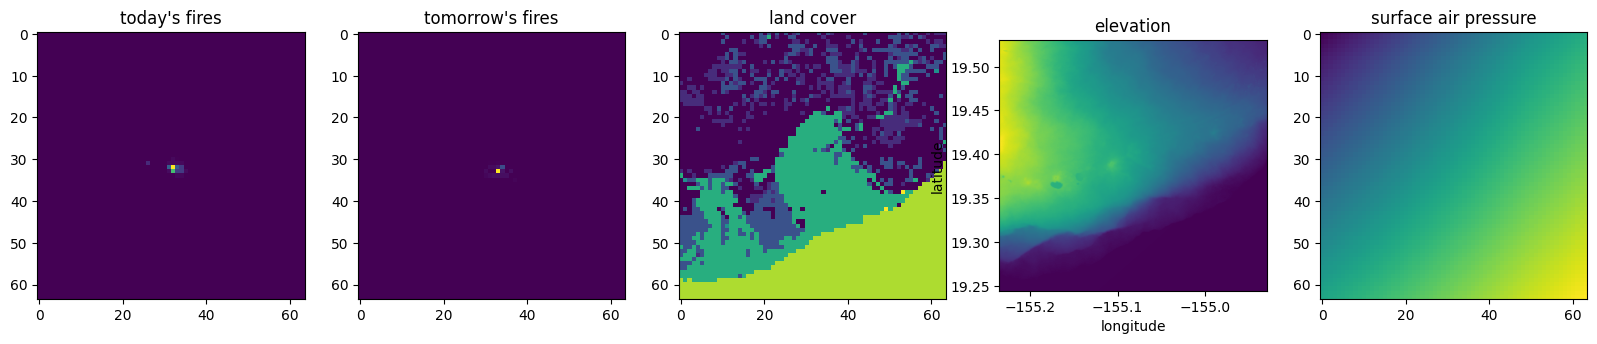

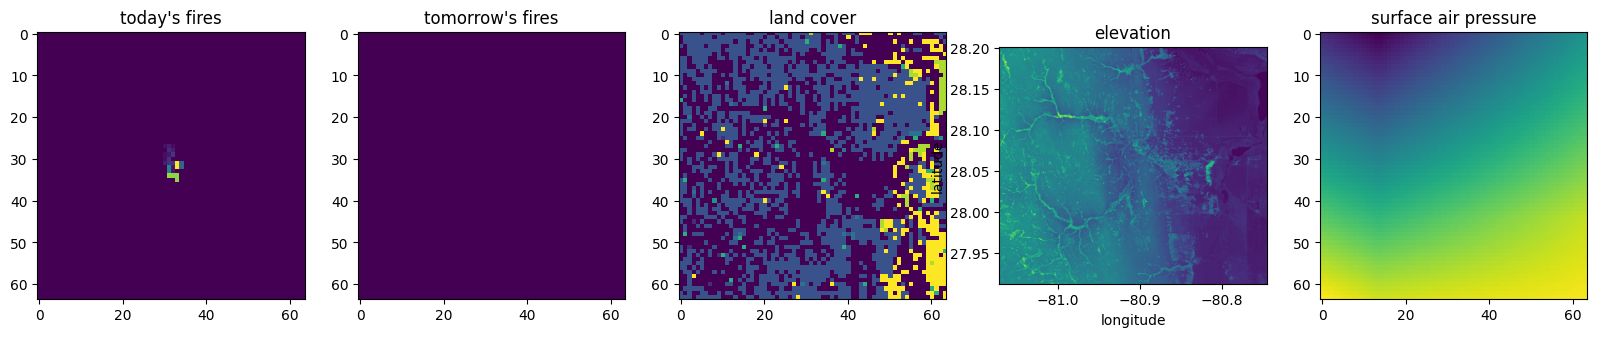

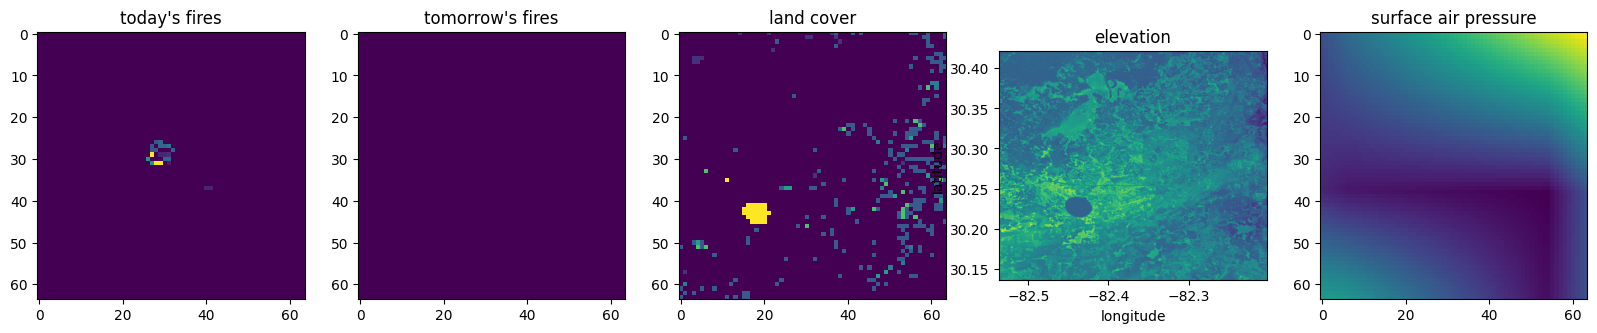

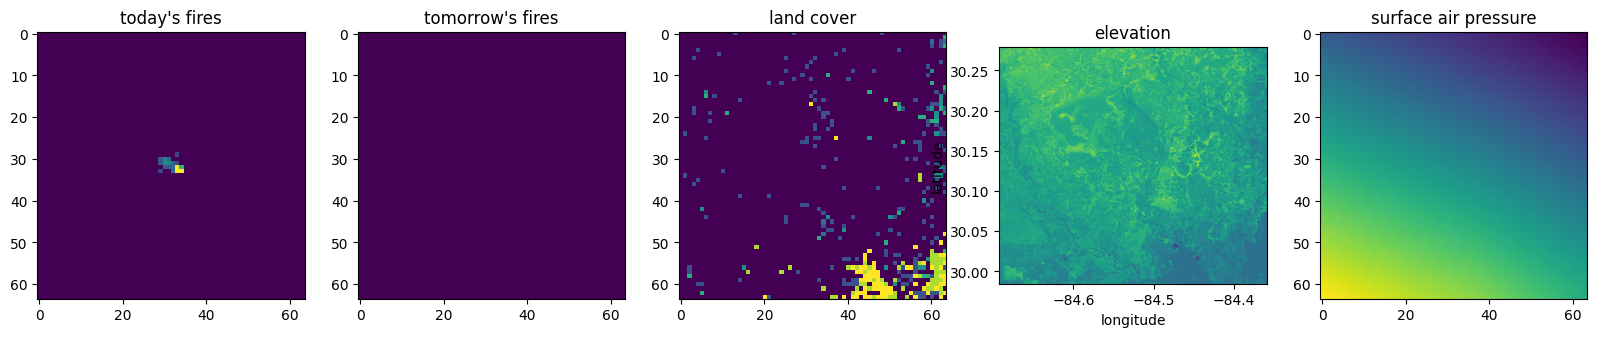

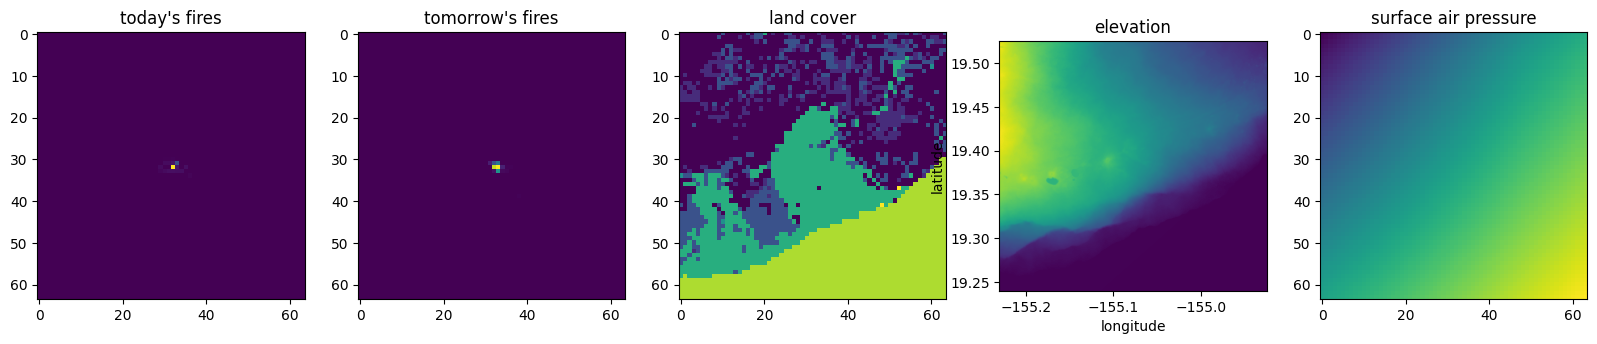

In [64]:
from rasterio import plot

for i in range(5):

  fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,20))
  im = ax1.imshow(first_5_fire[i].frp)
  ax1.title.set_text('today\'s fires')
  im = ax2.imshow(first_5_tomorrow_fire[i].frp)
  ax2.title.set_text('tomorrow\'s fires')
  im = ax3.imshow(first_5_landcover[i])
  ax3.title.set_text('land cover')
  ax4 = plot.show(first_5_ele[i][0], transform=first_5_ele[i][1]['transform'], ax=ax4)
  ax4.set_title('elevation')
  ax4.set_xlabel('longitude')
  ax4.set_ylabel('latitude')
  im = ax5.imshow(surface_air_pressure[i])
  ax5.title.set_text('surface air pressure')


## Putting data on Google Drive

In [65]:
import csv
import gzip

In [66]:
# erase and make new folder
#import shutil
#shutil.rmtree('drive/MyDrive/day_fire_data')
#os.mkdir('drive/MyDrive/day_fire_data')

https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Datasets/Climate_Data_ERA5_AWS.html  
Chose mean sea level air pressure because most commonly used, adjusted for elevation: https://www.weather.gov/bou/pressure_definitions

In [67]:
features = ['air_pressure_at_mean_sea_level',
 #'air_temperature_at_2_metres',
 'air_temperature_at_2_metres_1hour_Maximum',
 'air_temperature_at_2_metres_1hour_Minimum',
 'eastward_wind_at_10_metres',
 'integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation', # solar radiation
 'northward_wind_at_10_metres',
 'precipitation_amount_1hour_Accumulation']
 #'surface_air_pressure']

## Write to Google Drive

In [68]:
def write_frp(start, end):

  fr = get_frame(start)
  chip = manifest.iloc[start]
  chip_idx, left, bottom, top, right, epsg, chip_date = chip["idx"], chip["left"], chip["bottom"], chip["top"], chip["right"], chip["epsg"], chip["date"]
  sel = int(chip_date.split('-')[0]) - 2012
  choice = sel

  for i in range(start, end):
    chip = manifest.iloc[i]
    chip_idx, left, bottom, top, right, epsg, chip_date = chip["idx"], chip["left"], chip["bottom"], chip["top"], chip["right"], chip["epsg"], chip["date"]
    sel = int(chip_date.split('-')[0]) - 2012

    if sel != choice:
      choice = sel
      fr = get_frame(sel)
    b = process(i, fr)
    with gzip.open("drive/MyDrive/file/day_fire_data/today_frp_" + str(i) + ".gz", mode="wt") as f:
    #with open("drive/MyDrive/day_fire_data/today_frp_" + str(i) + ".csv", "w") as f:
      wr = csv.writer(f)
      z = np.array(b.frp)
      for a in z:
        y = [x for x in a]
        wr.writerow(y)
    with gzip.open("drive/MyDrive/file/day_fire_data/today_fire_" + str(i) + ".gz", mode="wt") as f:
      wr = csv.writer(f)
      z = np.array(b.bool)
      for a in z:
        y = [x for x in a]
        wr.writerow(y)

In [69]:
def write_atmospheric(r):
  for i in range(r):
    chip = manifest.iloc[i]
    chip_idx, left, bottom, top, right, epsg, chip_date = chip["idx"], chip["left"], chip["bottom"], chip["top"], chip["right"], chip["epsg"], chip["date"]
    b = atmospheric_from_topleft([top, left], epsg, chip_date, DEFAULT_PARAMS)

    with gzip.open("drive/MyDrive/file/day_fire_data/today_air_pressure_" + str(i) + ".gz", mode ="wt") as f:
      wr = csv.writer(f)
      q = getattr(b, 'air_pressure_at_mean_sea_level').values[0]
      for a in q:
        y = [x for x in a]
        wr.writerow(y)

    north = getattr(b, 'northward_wind_at_10_metres').values[0]
    east = getattr(b, 'eastward_wind_at_10_metres').values[0]

    with gzip.open("drive/MyDrive/file/day_fire_data/today_wind_speed_" + str(i) + ".gz", mode ="wt") as f:
      wr = csv.writer(f)
      q = np.sqrt(north**2 + east**2)
      for a in q:
        y = [x for x in a]
        wr.writerow(y)

    with gzip.open("drive/MyDrive/file/day_fire_data/today_wind_direction_" + str(i) + ".gz", mode ="wt") as f:
      wr = csv.writer(f)
      v = np.arctan2(-north, -east)
      q = np.degrees(v)
      for a in q:
        y = [x for x in a]
        wr.writerow(y)

    with gzip.open("drive/MyDrive/file/day_fire_data/today_tmax_" + str(i) + ".gz", mode ="wt") as f:
      wr = csv.writer(f)
      q = getattr(b, 'air_temperature_at_2_metres_1hour_Maximum').values[0] - 273.15
      for a in q:
        y = [x for x in a]
        wr.writerow(y)

    with gzip.open("drive/MyDrive/file/day_fire_data/today_tmin_" + str(i) + ".gz", mode ="wt") as f:
      wr = csv.writer(f)
      q = getattr(b, 'air_temperature_at_2_metres_1hour_Minimum').values[0] - 273.15
      for a in q:
        y = [x for x in a]
        wr.writerow(y)

    with gzip.open("drive/MyDrive/file/day_fire_data/today_solar_radiation_" + str(i) + ".gz", mode ="wt") as f:
      wr = csv.writer(f)
      q = getattr(b, 'integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation').values[0]
      for a in q:
        y = [x for x in a]
        wr.writerow(y)

    with gzip.open("drive/MyDrive/file/day_fire_data/today_precipitation_" + str(i) + ".gz", mode ="wt") as f:
      wr = csv.writer(f)
      q = getattr(b, 'precipitation_amount_1hour_Accumulation').values[0]
      for a in q:
        y = [x for x in a]
        wr.writerow(y)


In [71]:
  # chip = manifest.iloc[0]
  # chip_idx, left, bottom, top, right, epsg, chip_date = chip["idx"], chip["left"], chip["bottom"], chip["top"], chip["right"], chip["epsg"], chip["date"]
  # atmospheric_from_topleft([top, left], epsg, chip_date, DEFAULT_PARAMS)
  #write_atmospheric(1)

In [74]:
def write_tomorrow_fire_frp(start, end):

  fr = get_tomorrow_frame(start)
  chip = manifest.iloc[start]
  chip_idx, left, bottom, top, right, epsg, chip_date = chip["idx"], chip["left"], chip["bottom"], chip["top"], chip["right"], chip["epsg"], chip["date"]
  tomorrows_date = (datetime.strptime(chip_date, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d')
  sel = int(tomorrows_date.split('-')[0]) - 2012
  choice = sel

  for i in range(start, end):
    chip = manifest.iloc[i]
    chip_idx, left, bottom, top, right, epsg, chip_date = chip["idx"], chip["left"], chip["bottom"], chip["top"], chip["right"], chip["epsg"], chip["date"]
    tomorrows_date = (datetime.strptime(chip_date, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d')
    sel = int(tomorrows_date.split('-')[0]) - 2012

    if sel != choice:
      choice = sel
      fr = get_frame(sel)
    b = process_tomorrow(i, fr)
    with gzip.open("drive/MyDrive/file/day_fire_data/tomorrow_frp_" + str(i) + ".gz", mode="wt") as f:
    #with open("drive/MyDrive/day_fire_data/today_frp_" + str(i) + ".csv", "w") as f:
      wr = csv.writer(f)
      z = np.array(b.frp)
      for a in z:
        y = [x for x in a]
        wr.writerow(y)
    with gzip.open("drive/MyDrive/file/day_fire_data/tomorrow_fire_" + str(i) + ".gz", mode="wt") as f:
      wr = csv.writer(f)
      z = np.array(b.bool)
      for a in z:
        y = [x for x in a]
        wr.writerow(y)

In [75]:
def write_landcover(start, end):


  for i in range(start, end):
    chip = manifest.iloc[i]
    chip_idx, left, bottom, top, right, epsg, chip_date = chip["idx"], chip["left"], chip["bottom"], chip["top"], chip["right"], chip["epsg"], chip["date"]
    with gzip.open("drive/MyDrive/file/day_fire_data/today_landcover_" + str(i) + ".gz", mode ="wt") as f:
      wr = csv.writer(f)
      b = np.array(landcover_from_topleft([top, left], epsg))
      for a in b:
        y = [x for x in a]
        wr.writerow(y)

In [76]:
def write_elevation(start, end):


  for i in range(start, end):
    chip = manifest.iloc[i]
    chip_idx, left, bottom, top, right, epsg, chip_date = chip["idx"], chip["left"], chip["bottom"], chip["top"], chip["right"], chip["epsg"], chip["date"]
    with gzip.open("drive/MyDrive/file/day_fire_data/today_elevation_" + str(i) + ".gz", mode="wt") as f:
      wr = csv.writer(f)
      b = np.array(get_elevation([top, left], epsg)[0])
      print(b)
      for a in b:
        y = [x for x in a]
        wr.writerow(y)

## Read Data Back From Google Drive

In [77]:
def get_data_frp(i):
  u = []
  #with open("drive/MyDrive/day_fire_data/today_frp_" + str(i) + ".csv", mode ='r')as file:
  with gzip.open("drive/MyDrive/file/day_fire_data/today_frp_" + str(i) + ".gz", mode ='rt')as file:
    csvFile = csv.reader(file)
    for lines in csvFile:
      p = []
      for y in lines:
        p.append(float(y))
      u.append(p)
  return u

In [78]:
def get_tomorrow_data_frp(i):
  u = []
  #with open("drive/MyDrive/day_fire_data/today_frp_" + str(i) + ".csv", mode ='r')as file:
  with gzip.open("drive/MyDrive/file/day_fire_data/tomorrow_frp_" + str(i) + ".gz", mode ='rt')as file:
    csvFile = csv.reader(file)
    for lines in csvFile:
      p = []
      for y in lines:
        p.append(float(y))
      u.append(p)
  return u

In [79]:
def get_data_fire(i):
  u = []
  #with open("drive/MyDrive/day_fire_data/today_frp_" + str(i) + ".csv", mode ='r')as file:
  with gzip.open("drive/MyDrive/file/day_fire_data/today_fire_" + str(i) + ".gz", mode ='rt')as file:
    csvFile = csv.reader(file)
    for lines in csvFile:
      p = []
      for y in lines:
        p.append(float(y))
      u.append(p)
  return u

In [80]:
def get_tomorrow_data_fire(i):
  u = []
  #with open("drive/MyDrive/day_fire_data/today_frp_" + str(i) + ".csv", mode ='r')as file:
  with gzip.open("drive/MyDrive/file/day_fire_data/tomorrow_fire_" + str(i) + ".gz", mode ='rt')as file:
    csvFile = csv.reader(file)
    for lines in csvFile:
      p = []
      for y in lines:
        p.append(float(y))
      u.append(p)
  return u

In [81]:
def get_data_landcover(i):
  u = []
  with gzip.open("drive/MyDrive/file/day_fire_data/today_landcover_" + str(i) + ".gz", mode ='rt')as file:
    csvFile = csv.reader(file)
    for lines in csvFile:
      p = []
      for y in lines:
        p.append(float(y))
      u.append(p)
  return u

In [82]:
def get_data_elevation(i):
  u = []
  with gzip.open("drive/MyDrive/file/day_fire_data/today_elevation_" + str(i) + ".gz", mode ='rt')as file:
    csvFile = csv.reader(file)
    for lines in csvFile:
      p = []
      for y in lines:
        p.append(float(y))
      u.append(p)
  return u

In [83]:
def get_wind_speed(i):
  u = []
  with gzip.open("drive/MyDrive/file/day_fire_data/today_wind_speed_" + str(i) + ".gz", mode ='rt')as file:
    csvFile = csv.reader(file)
    for lines in csvFile:
      p = []
      for y in lines:
        p.append(float(y))
      u.append(p)
  return u

In [84]:
def get_air_pressure(i):
  u = []
  with gzip.open("drive/MyDrive/file/day_fire_data/today_air_pressure_" + str(i) + ".gz", mode ='rt')as file:
    csvFile = csv.reader(file)
    for lines in csvFile:
      p = []
      for y in lines:
        p.append(float(y))
      u.append(p)
  return u

In [85]:
def get_wind_direction(i):
  u = []
  with gzip.open("drive/MyDrive/file/day_fire_data/today_wind_direction_" + str(i) + ".gz", mode ='rt')as file:
    csvFile = csv.reader(file)
    for lines in csvFile:
      p = []
      for y in lines:
        p.append(float(y))
      u.append(p)
  return u

In [86]:
def get_temp_max(i):
  u = []
  with gzip.open("drive/MyDrive/file/day_fire_data/today_tmax_" + str(i) + ".gz", mode ='rt')as file:
    csvFile = csv.reader(file)
    for lines in csvFile:
      p = []
      for y in lines:
        p.append(float(y))
      u.append(p)
  return u

In [87]:
def get_temp_min(i):
  u = []
  with gzip.open("drive/MyDrive/file/day_fire_data/today_tmin_" + str(i) + ".gz", mode ='rt')as file:
    csvFile = csv.reader(file)
    for lines in csvFile:
      p = []
      for y in lines:
        p.append(float(y))
      u.append(p)
  return u

In [88]:
def get_solar_radiation(i):
  u = []
  with gzip.open("drive/MyDrive/file/day_fire_data/today_solar_radiation_" + str(i) + ".gz", mode ='rt')as file:
    csvFile = csv.reader(file)
    for lines in csvFile:
      p = []
      for y in lines:
        p.append(float(y))
      u.append(p)
  return u

In [89]:
def get_precipitation(i):
  u = []
  with gzip.open("drive/MyDrive/file/day_fire_data/today_precipitation_" + str(i) + ".gz", mode ='rt')as file:
    csvFile = csv.reader(file)
    for lines in csvFile:
      p = []
      for y in lines:
        p.append(float(y))
      u.append(p)
  return u

## Writing All Data to Google Drive

In [90]:
#write_frp(19850, len(manifest))
#write_landcover(len(manifest))
#write_elevation(len(manifest))
len(manifest)

21550

In [ ]:
write_atmospheric(len(manifest))

In [91]:
#### Need to run
#write_elevation(722, len(manifest))


# comment out frp
#write_frp(0, 8610)

In [92]:
    # for var in list(atmos.data_vars):
    #     data_arr = getattr(atmos, var).values[0]
    #     np.save(output_dir.joinpath(f'{var}.npy'), data_arr)

In [93]:
  # chip = manifest.iloc[i]
  # chip_idx, left, bottom, top, right, epsg, chip_date = chip["idx"], chip["left"], chip["bottom"], chip["top"], chip["right"], chip["epsg"], chip["date"]
  # first_5_landcover.append(landcover_from_topleft([top, left], epsg))
  # first_5_ele.append(get_elevation([top, left], epsg))
  # first_5_atmos.append(atmospheric_from_topleft([top, left], epsg, chip_date, DEFAULT_PARAMS))
  # first_5_tomorrow_fire.append(process_tomorrow(i))

## Test on single fire

In [98]:
#write_frp(0, 1)
# write_landcover(1)
# write_elevation(1)
#write_tomorrow_fire_frp(0,1)
write_atmospheric(1)

In [95]:
#write_elevation(0,1)

In [99]:
#y = get_data_elevation(1)

In [100]:
t = get_precipitation(0)
u = get_air_pressure(0)
v = get_wind_direction(0)
w = get_wind_speed(0)
x = get_solar_radiation(0)
y = get_temp_min(0)
z = get_temp_max(0)

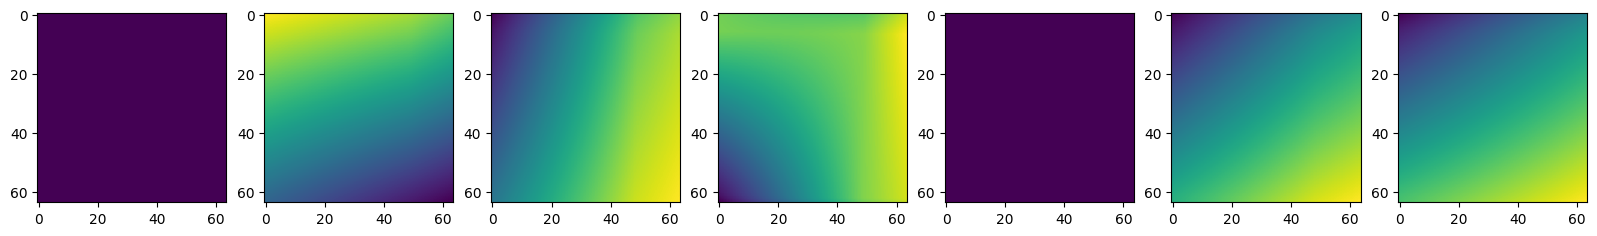

In [101]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(20,20))
im = ax1.imshow(t)
im = ax2.imshow(u)
im = ax3.imshow(v)
im = ax4.imshow(w)
im = ax5.imshow(x)
im = ax6.imshow(y)
im = ax7.imshow(z)

In [ ]:
frp_data = get_data_frp(0)
landcover_data = get_data_landcover(0)
elevation_data = get_data_elevation(0)
f_data = get_data_fire(0)

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,20))
im = ax1.imshow(frp_data)
im = ax2.imshow(landcover_data)
im = ax3.imshow(elevation_data)
im = ax4.imshow(f_data)


In [ ]:
u = get_tomorrow_data_frp(0)
v = get_tomorrow_data_fire(0)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
im = ax1.imshow(u)
im = ax2.imshow(v)